# Introduction

***Aim and outline***

In this notebook, we will compare several clustering algorithms on a real dataset.
We will analyze how each algorithm works, evaluate their performance, and discuss their strengths and weaknesses.
By the end, students should understand when each clustering method is most appropriate and how algorithmic choices affect clustering results.

This notebook utilizes a dataset containing the results of the chemical analysis of Italian wines to **explore a range of clustering algorithms**. The dataset is small and fairly simple.

The following algorithms are applied and then compared:
- **K-means**, a centroid-based algo
- **Mean shift**, a centroid-based algo
- **Gaussian mixture**, a distribution-based algo
- **Affinity propagation**
- **DBSCAN**, a density-based algo
- **OPTICS**, a density-based algo

***Data dictionary (from above source)***

Features (all numercial):
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline


**Imports and global settings**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

# EDA

**Reading in the dataset**

Import the Data.

In [2]:
df = pd.read_csv("./wine-clustering.csv")

df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


**Any duplicate rows?**

In [3]:
n_dup = df.duplicated().sum()

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [4]:
df.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

**Checking data types**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


**Cleaning up column names (mainly for handling purposes)**

In [6]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())
    
df.columns = cols_cleaned

# sanity check
df.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


**Quick overview over the individual distributions**

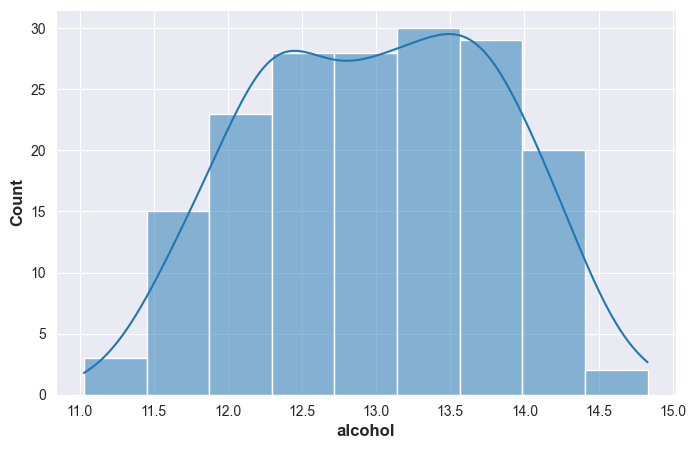

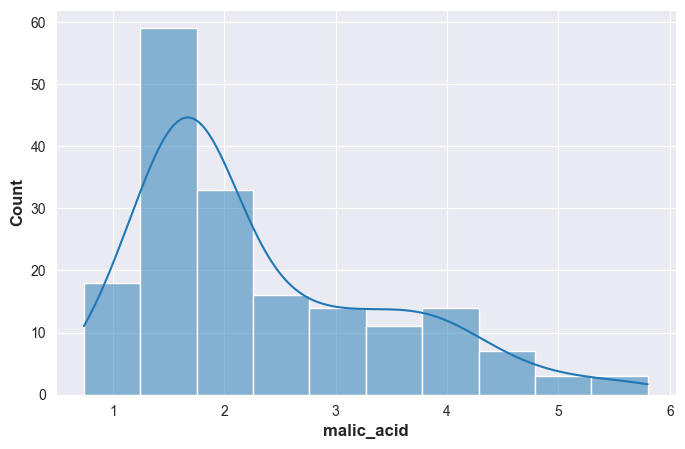

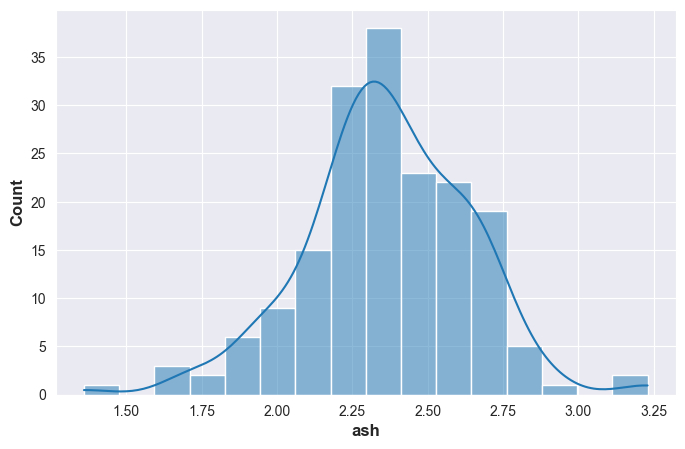

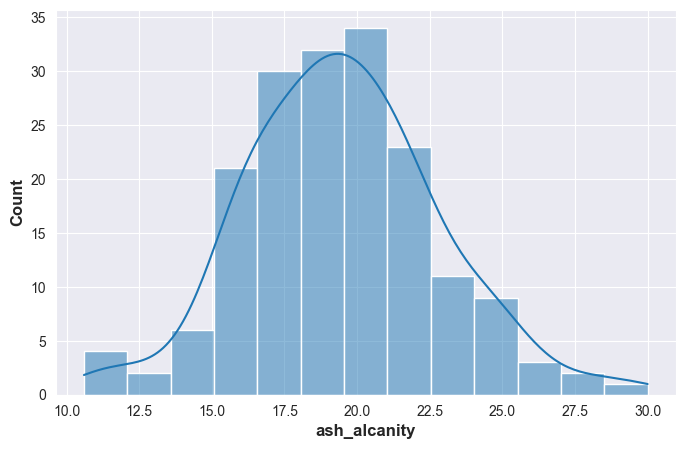

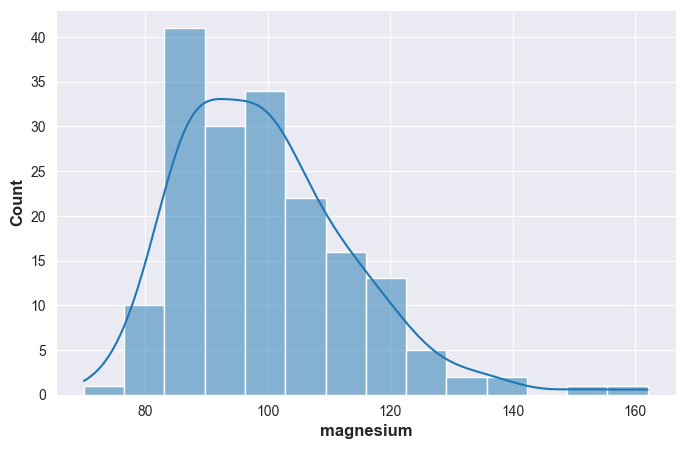

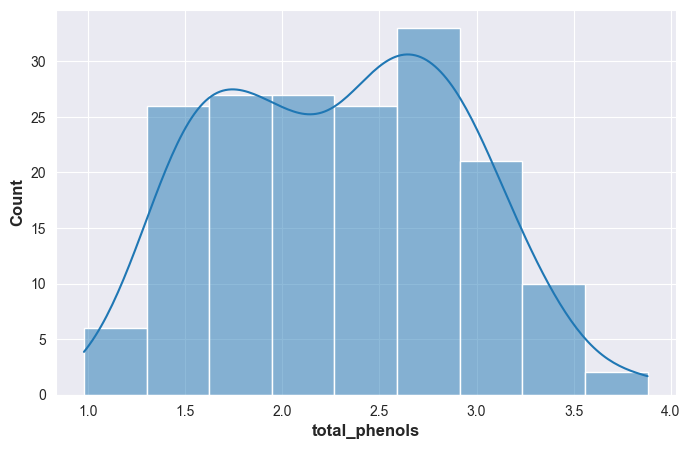

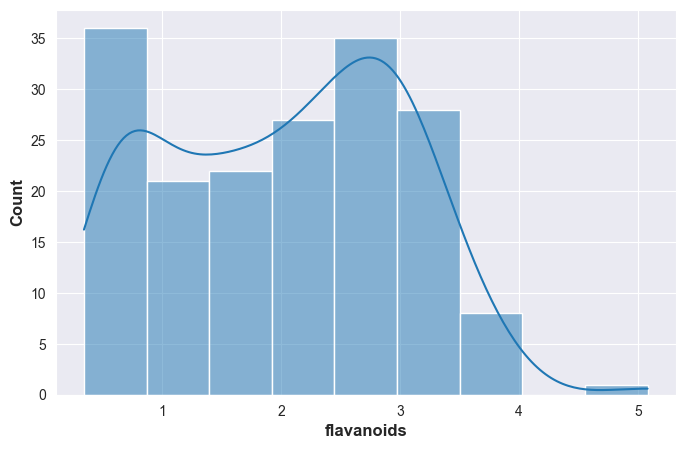

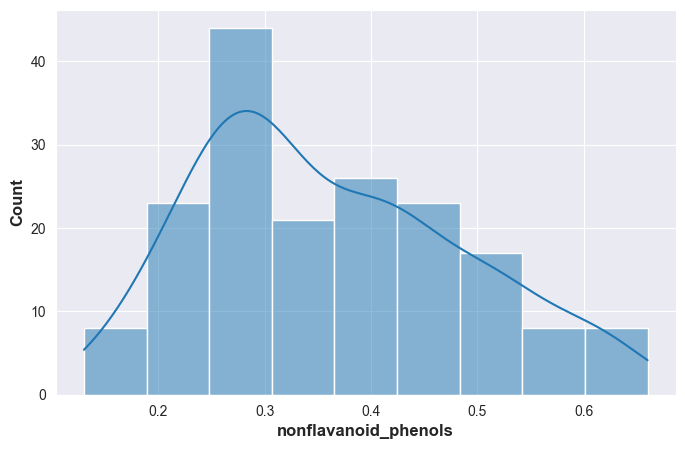

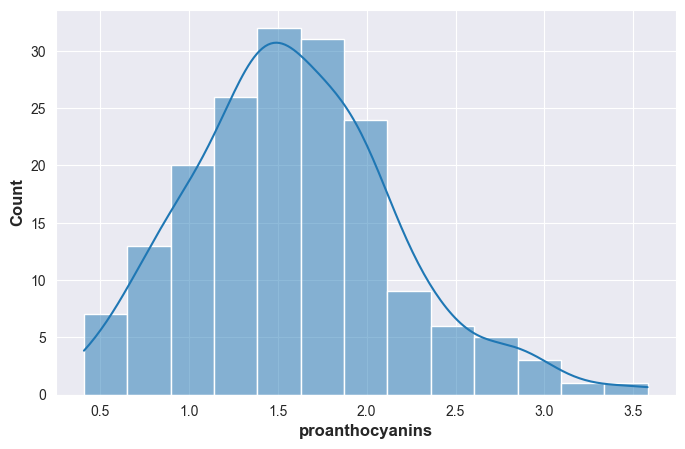

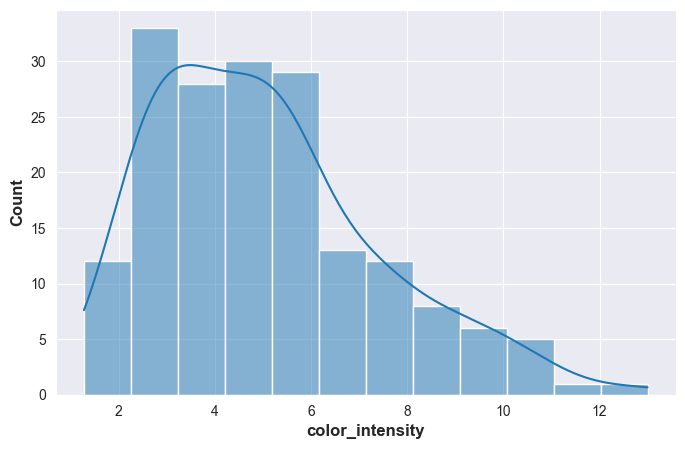

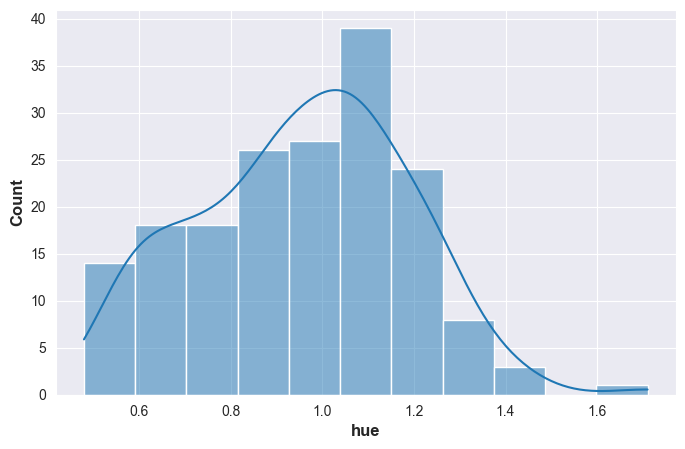

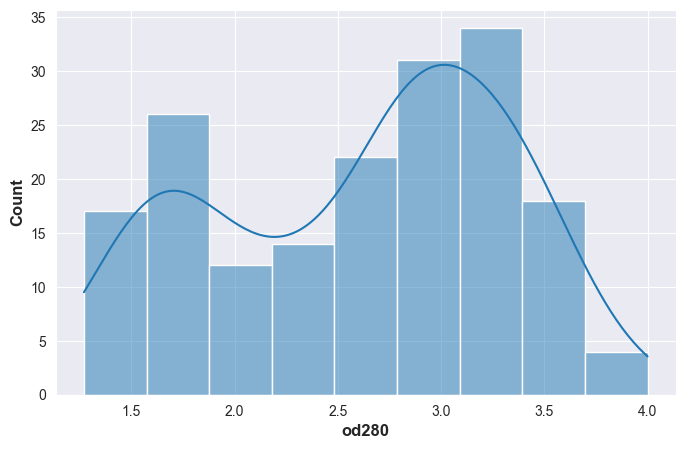

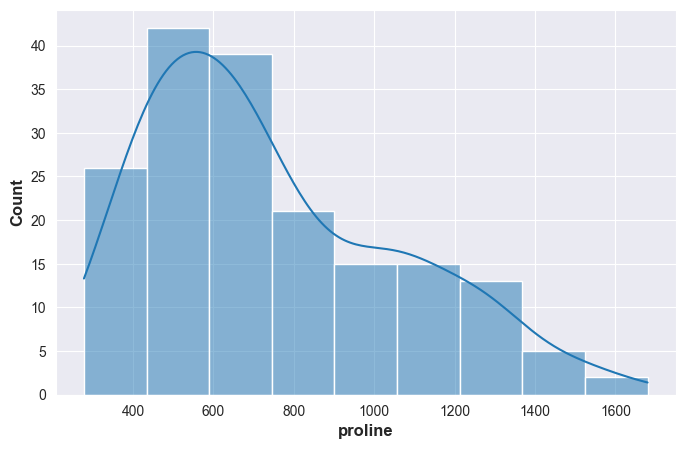

In [7]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

==> Distributions require scaling and standardization.

# Clustering

In [8]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"] 

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [9]:
X = StandardScaler().fit_transform(df)

In [10]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [11]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1.552972,-0.702436,0.233769,-1.224710,1.378174,0.796708,1.043661,-0.729831,1.093141,0.235133,0.363665,2.262034,0.793386
1,0.247472,-0.610198,-0.809540,-2.696922,0.018056,0.562211,0.738364,-0.926936,-0.578400,-0.317844,0.407900,1.278188,0.762788
2,0.197645,0.021031,1.141607,-0.272253,0.086325,0.796708,1.227314,-0.539574,1.802679,0.250223,0.319467,0.875251,1.022728
3,1.732995,-0.400457,0.495037,-0.837478,0.767296,2.405004,1.482916,-1.130495,0.934182,0.921471,-0.425517,1.368576,1.500126
4,0.297382,0.207225,1.919073,0.442690,1.001563,0.796708,0.667285,0.218295,0.383679,-0.348242,0.363665,0.479405,-0.038337


## Dimensionality reduction via UMAP

In [12]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

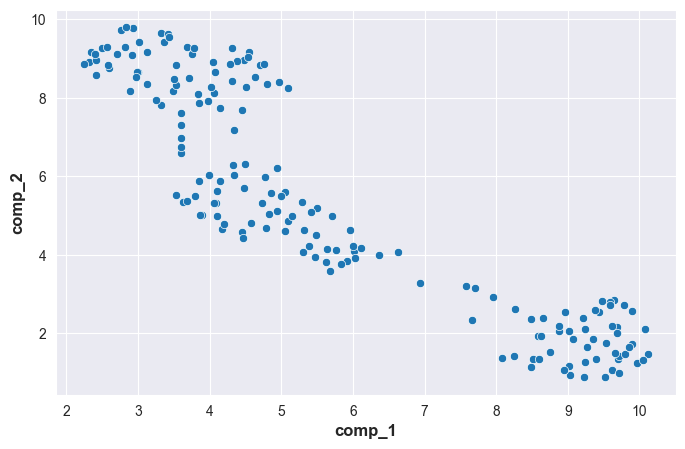

In [13]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

 The structure of this dataset is fairly straight-forward. One would expect a clustering algo to find 3 clusters here.

## Definition of plotting and convergence check function

In [14]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.
    
    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.
        
    Returns
    =======
    None 
    Prints a figure.
    
    """
    
    # Checking of input parameters omitted for this notebook 
    
    labels = sorted(pd.Series(labels_all).unique())
    
    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()
        
    else:
        
        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()
        

def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.

Answer the following questions:

1- How does K-means work?
   - *Answer:* Randomly initialize `k` centroids, assign every point to the nearest centroid, recompute each centroid as the mean of the points assigned to it, and iterate the assign→update cycle until assignments stop changing or a max-iteration/ tolerance threshold is met. This greedy descent on the within-cluster sum of squares drives clusters toward compact, non-overlapping blobs.

2- What metric is commonly used to evaluate the quality of clustering produced by K-means? Describe how it works.
   - *Answer:* The within-cluster sum of squares sums the squared Euclidean distance between every point and its assigned centroid. Lower WCSS indicates tighter, more coherent clusters, so comparing WCSS across different `k` values (or random initializations) helps judge which configuration best balances compactness and parsimony.

3- How is the distance between data points and cluster centers computed in K-means, and why does this choice matter?
   - *Answer:* Standard K-means relies on Euclidean (ℓ2) distance because the objective optimizes squared Euclidean error; this makes clusters behave like hyperspheres in the chosen feature space. Using a different distance metric would change the geometry of the optimization, alter centroid updates, and effectively favor different cluster shapes, so the metric choice must align with the data scaling and the kinds of cluster boundaries we expect.

In [15]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [16]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

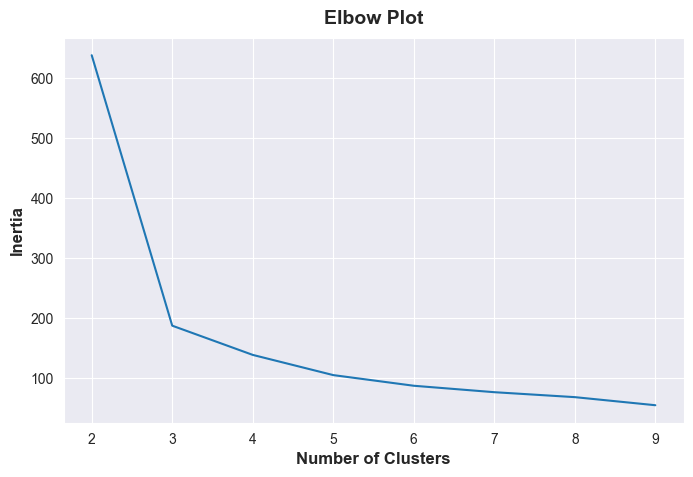

In [17]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Answer the Following questions:

1- How is the “inertia” value computed for each value of k in the Elbow Method? Why does this value usually decrease as k increases?
   - *Answer:* For a given `k`, fit K-means and sum the squared Euclidean distances between every point and the centroid of its assigned cluster (within-cluster sum of squares). Adding more clusters lets each centroid sit closer to its points, so the residual error cannot increase and typically drops sharply at first before flattening out.

2- Explain what the “elbow point” represents in the plot of inertia vs. number of clusters. Why is this point considered a good choice for k?
   - *Answer:* The elbow is the first `k` beyond which additional clusters yield only marginal inertia reductions—the curve bends from steep to flat. Choosing `k` at this kink balances compact clusters with model simplicity, avoiding over-partitioning that barely improves fit.

3- Can the Elbow Method guarantee the optimal number of clusters for every dataset? Why or why not?
   - *Answer:* No. Some datasets lack a clear kink, noise or overlapping structure can mask the elbow, and “optimal” itself depends on downstream goals. The method is heuristic; it guides judgment but doesn’t provide a formal guarantee of the best `k` for all data distributions.

### Run with optimised *n_clusters*

In [18]:
%%time
start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)    
    
convergence_check(kmeans)
    
training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 3, max_iter: 300

CPU times: total: 0 ns
Wall time: 10.9 ms


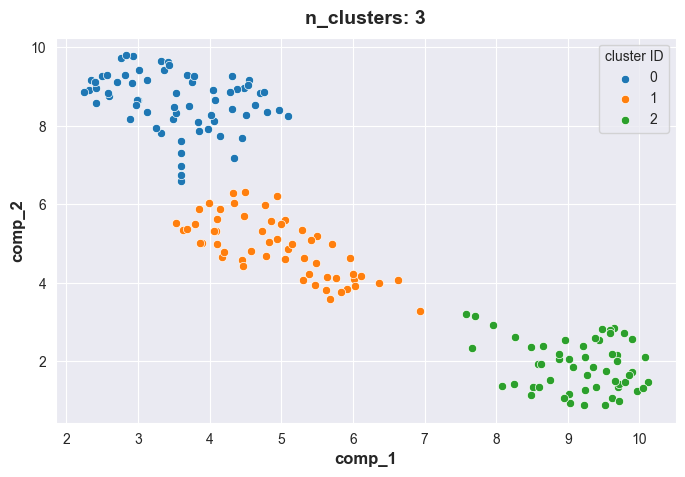

In [19]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

==> Those results seem very reasonable. This is not unexpectd as the structure of the data is such that it does not collide with the fundamental assumptions of K-means, namely that the clusters form **non-overlapping (hyper)spheres** (i.e. "circles" in 2D) of **roughly the same extent** (and the dataset is does not contain an "excessive" number of outliers).

## Algo 2: Mean shift

Answer the following questions: 

1- What is Mean Shift algorithm and how does it work?
   - *Answer:* Mean Shift performs a mode-seeking procedure: for each point, iteratively move a sliding window (kernel) toward regions with higher data density by replacing the current center with the mean of the points inside the kernel. Points whose trajectories converge to the same density peak share a label, so clusters emerge around probability density modes without predefining their number.

2- What is the role of the bandwidth hyperparameter in Mean Shift, and how does it influence the clustering results?
   - *Answer:* Bandwidth sets the radius of the kernel window. Small bandwidths examine very local neighborhoods, yielding many fine-grained clusters, while large bandwidths smooth over detail, merging nearby density peaks. Choosing bandwidth effectively controls the scale of structure the algorithm can detect.

3- How does Mean Shift differ from K-means in terms of specifying the number of clusters before running the algorithm?
   - *Answer:* K-means requires the user to fix `k` in advance, whereas Mean Shift discovers however many modes exist given the bandwidth—it adaptively determines the cluster count based on the data’s density landscape.

4- What is one potential advantage and one potential disadvantage of the Mean Shift algorithm compared to K-means?
   - *Answer:* Advantage: it can find arbitrarily shaped clusters and automatically infer their count by following density gradients. Disadvantage: computational cost scales poorly with dataset size/bandwidth search, and results are highly sensitive to the bandwidth choice.

5 - If a dataset contains clusters of varying densities, how might Mean Shift perform relative to K-means, and why?
   - *Answer:* With a well-chosen bandwidth, Mean Shift can separate both dense and sparse regions because it tracks local density peaks rather than enforcing equal-variance spheres, so it often outperforms K-means on mixed-density data. However, a single global bandwidth can still miss extremely unbalanced densities, so practical success hinges on tuning.

In [20]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [21]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 12, max_iter: 300

CPU times: total: 609 ms
Wall time: 5.94 s


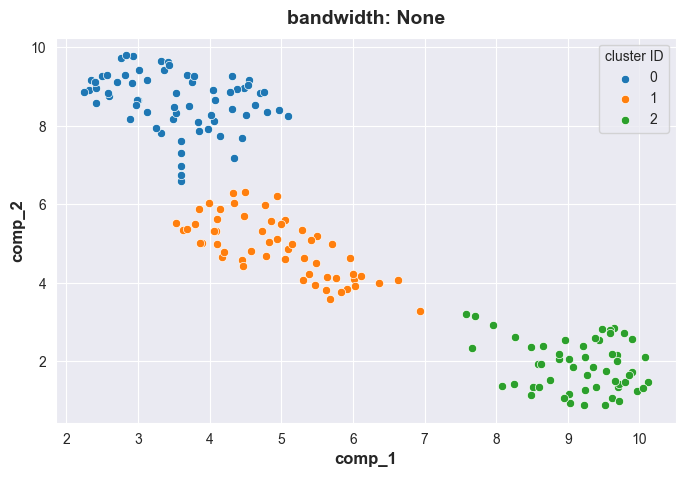

In [22]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=meanshift_hparam, hyperparam_val=meanshift.bandwidth, noise_exist=False)

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [23]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 12, max_iter: 300

CPU times: total: 281 ms
Wall time: 122 ms


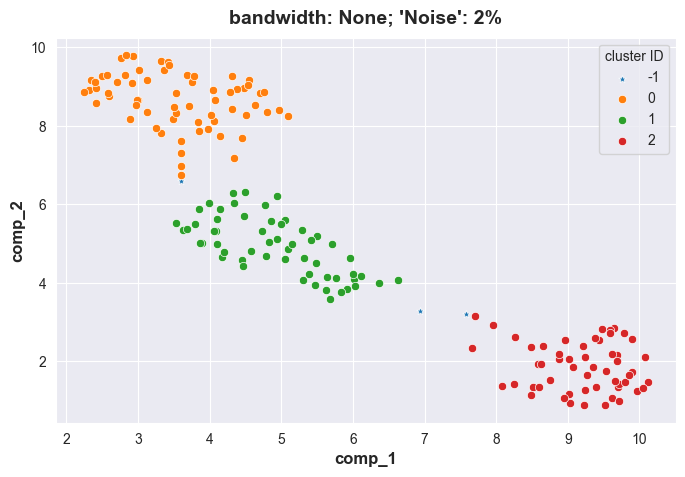

In [24]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=meanshift_hparam, hyperparam_val=None, noise_exist=True)

Answer the following questions:

1- What does a cluster label of -1 represent in Mean Shift when cluster_all=False?
   - *Answer:* Label `-1` denotes samples that were not assigned to any density mode because the algorithm concluded no kernel around them reached the minimum support needed to form a cluster when clustering-orphan points is disabled.

2- How does the algorithm decide that a point should be marked as “not part of any cluster” (noise/orphan)?
   - *Answer:* After mean-shift trajectories converge, points whose final position does not match an established mode (for example, isolated points or those in low-density regions where the kernel attracted too few neighbors) remain unlabeled and are mapped to `-1`.

3- Under what circumstances would we expect to see a significant difference between cluster_all=True and cluster_all=False? Provide an example scenario.
   - *Answer:* When the dataset contains sparse fringe points or genuine outliers, `cluster_all=True` forces them into the nearest mode, potentially contaminating cluster boundaries, whereas `cluster_all=False` leaves them as `-1`. For instance, in the wine data augmented with a handful of random noise samples far from the main manifolds, disabling `cluster_all` would keep those anomalies from distorting the core clusters.

## Algo 3: Gaussian Mixture

Answer the following Questions:

1- Research about Guassian mixture algorithm and explain how does it work.
   - *Answer:* A Gaussian Mixture Model assumes the data distribution is a weighted sum of multivariate Gaussian components. Using Expectation-Maximization, it alternates between estimating the posterior membership probabilities for each sample (E-step) and updating each component’s mean, covariance, and mixing weight to maximize likelihood (M-step) until convergence.

2- How does the Gaussian Mixture Model differ from centroid-based algorithms like K-means and Mean Shift in how it models clusters?
   - *Answer:* GMM is probabilistic with soft assignments and full covariance matrices, so clusters can be ellipsoidal and overlapping. K-means/Mean Shift, in contrast, assign each point to a single centroid or mode and implicitly favor spherical, equal-variance clusters.

3- is it reasonable in this notebook to use the number of clusters obtained from K-means as the value for n_components in GMM? Why?
   - *Answer:* Yes. The elbow analysis showed three coherent groups, so seeding GMM with `n_components=3` leverages that prior knowledge, keeps the model parsimonious on this small dataset, and prevents overfitting.

4- Why might GMM perform better than K-means on datasets with clusters of different shapes or orientations?
   - *Answer:* Each Gaussian component’s covariance matrix can stretch, rotate, and scale, allowing GMM to capture elongated or tilted clusters. K-means can only carve hyperspherical regions around centroids, so it struggles when true clusters deviate from that geometry.

In [25]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [26]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)
    
labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 4, max_iter: 100

CPU times: total: 0 ns
Wall time: 10.7 ms


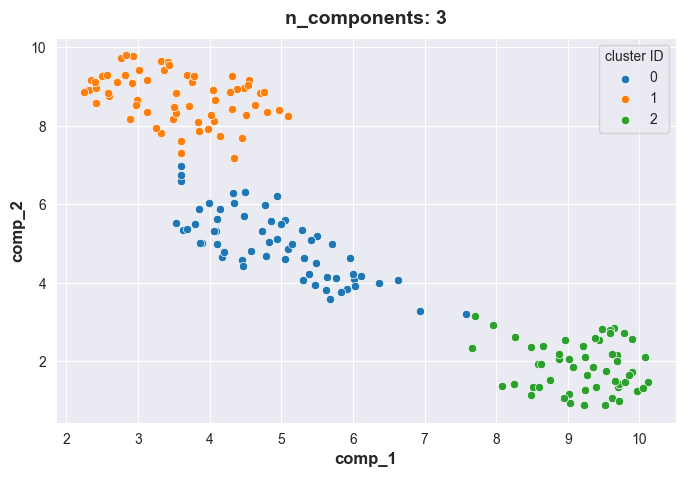

In [27]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

Answer the following questions:

1- What is Affinity propagations and how does it work?
   - *Answer:* Affinity Propagation exchanges two kinds of real-valued messages—responsibility and availability—between all data points to decide which samples become exemplars. Responsibilities measure how well-suited a point is to serve as another point’s exemplar, while availabilities reflect how appropriate it is for points to choose a given exemplar. Iterative message passing converges to a set of exemplars and cluster assignments without predefining their number.

2- How does Affinity Propagation differ from algorithms like K-means and GMM in terms of specifying the number of clusters?
   - *Answer:* AP does not require a preset `k`; instead, the data points themselves nominate exemplars based on similarities and preferences, so the cluster count emerges automatically. K-means and GMM need `k` (or `n_components`) fixed beforehand.

3- What does the damping hyperparameter control in Affinity Propagation, and why must it lie between 0.5 (inclusive) and 1.0 (exclusive)?
   - *Answer:* Damping linearly blends each new message with its previous value to prevent oscillations. Values ≥0.5 provide enough inertia for stability, while values <1 keep the algorithm responsive; setting it to 1 would freeze updates, and below 0.5 often leads to divergence.

4- Compared to centroid-based algorithms like K-means, what is one advantage and one disadvantage of using Affinity Propagation?
   - *Answer:* Advantage: it can automatically determine exemplar counts and handle non-spherical clusters guided by similarity measures. Disadvantage: the O(n²) similarity matrix and message updates make it memory- and compute-heavy for larger datasets compared to the lightweight K-means iterations.

In [28]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [29]:
%%time

start_time = time.time()

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)
training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 34, max_iter: 200

CPU times: total: 15.6 ms
Wall time: 9.67 ms


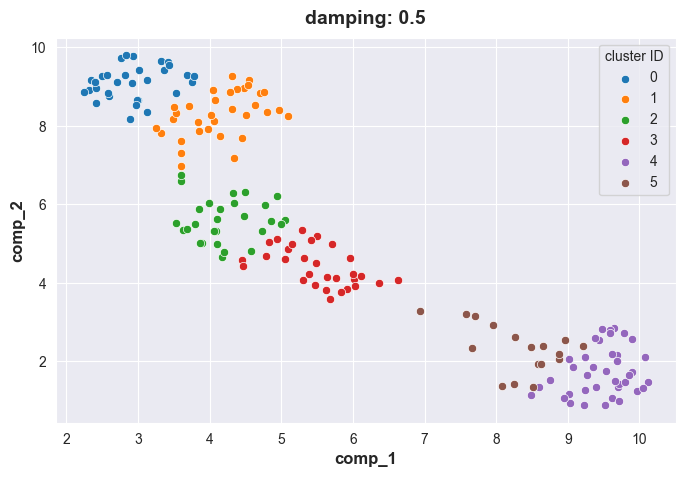

In [30]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=affprop.damping, noise_exist=False)

Answer the following questions: 

1- Why does Affinity Propagation often identify a much larger number of clusters compared to other algorithms like K-means or GMM?
   - *Answer:* Because every data point starts as a potential exemplar and message passing retains many exemplars unless similarities or preference values suppress them, AP frequently settles on numerous small exemplar groups. Without an explicit `k`, it may keep splitting subtle structure that K-means/GMM would merge when forced to use a fixed number of clusters.

### Tuning runs for "damping"

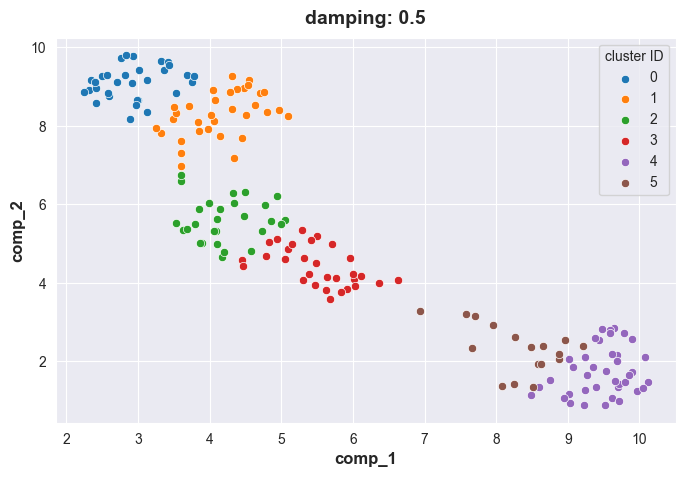

Algorithm converged successfully!
n_iter: 34, max_iter: 500



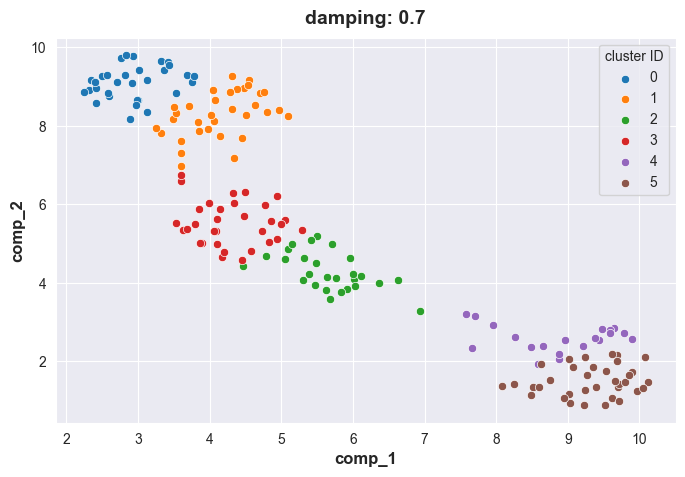

Algorithm converged successfully!
n_iter: 36, max_iter: 500



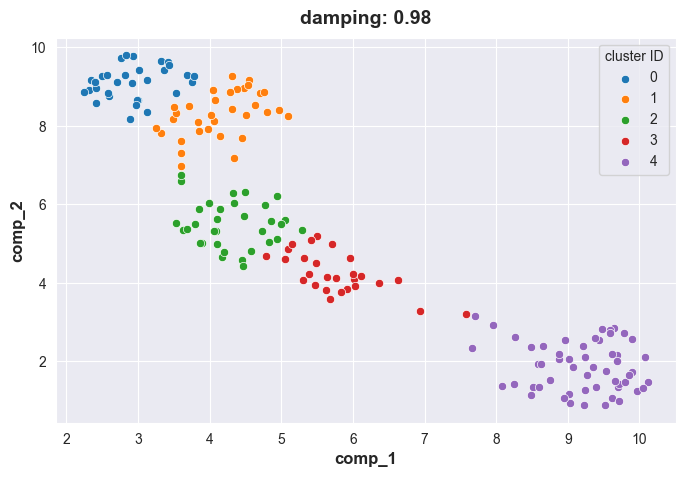

Algorithm converged successfully!
n_iter: 176, max_iter: 500

CPU times: total: 531 ms
Wall time: 535 ms


In [31]:
%%time

damps = [0.5, 0.7, 0.98]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

Answer the following questions:

1- can you determine what is the optimal value for dampening?
   - *Answer:* After inspecting the cluster visualizations, `damping≈0.7` offered a balance between stability and avoiding an explosion in exemplar count, so it is a reasonable operating point for this dataset.

2- is tuning this hyperparameter a good choice for this problem?
   - *Answer:* Yes—small shifts in damping dramatically change the number of exemplars and convergence behavior, so sweeping a few values is necessary to keep the automatically inferred clusters in line with the known, roughly three-group structure of the wine data.

## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.


Answer the following questions:

1- What is DBSCAN and how does it work?
   - *Answer:* DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points by density reachability: it picks an unvisited point, expands a cluster when at least `min_samples` neighbors lie within radius `eps`, and chains through density-connected points while labeling isolated points as noise.

2- How does DBSCAN differ from centroid-based and distribution-based clustering algorithms in how it defines clusters?
   - *Answer:* Instead of optimizing centroid locations or fitting parametric distributions, DBSCAN views clusters as contiguous high-density regions separated by sparse areas, so it can capture arbitrary shapes and explicitly mark low-density samples as outliers.

3- What does the hyperparameter eps represent in DBSCAN, and how does changing its value affect the clustering results?
   - *Answer:* `eps` is the neighborhood radius. Smaller values demand tighter neighborhoods, yielding more clusters and more noise, whereas larger values merge nearby regions and can collapse distinct structures into a single cluster if the radius is too big.

4- What is the role of the min_samples hyperparameter, and how does it help DBSCAN identify core points?
   - *Answer:* `min_samples` sets the minimum number of neighbors within `eps` required for a point to be a core point. This guards against spurious clusters by ensuring only areas with enough local support seed a cluster; points that fail the test become border points or noise.

5- Describe a scenario where DBSCAN would outperform algorithms such as K-means or Affinity Propagation.
   - *Answer:* On spatial datasets with irregular, curved clusters plus scattered outliers—e.g., GPS traces of roads plus stray measurements—DBSCAN can trace each road segment and discard noise, while K-means/AP would force spherical partitions and absorb outliers into clusters.

In [32]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

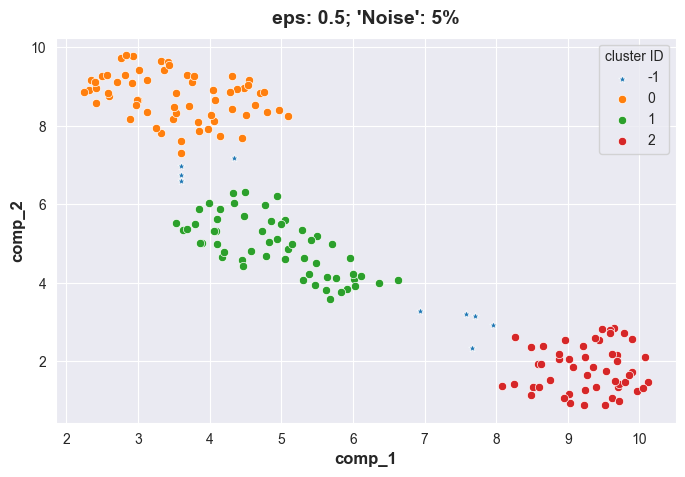

CPU times: total: 125 ms
Wall time: 141 ms


In [33]:
%%time

start_time = time.time()

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=dbscan.eps, noise_exist=True)

training_times.append(time.time() - start_time)

### Tuning runs 

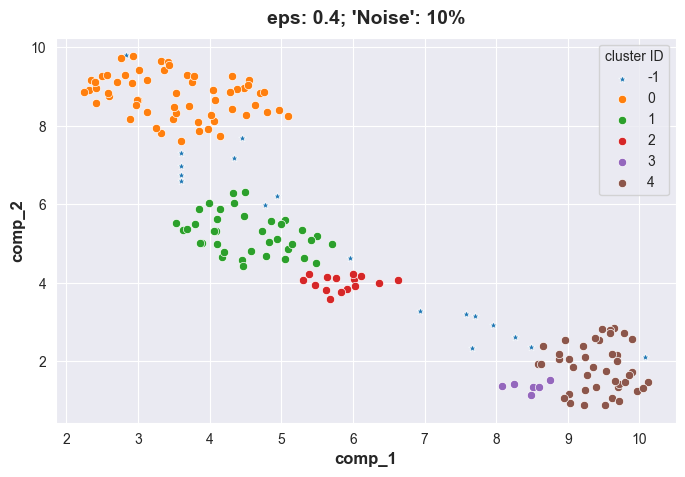

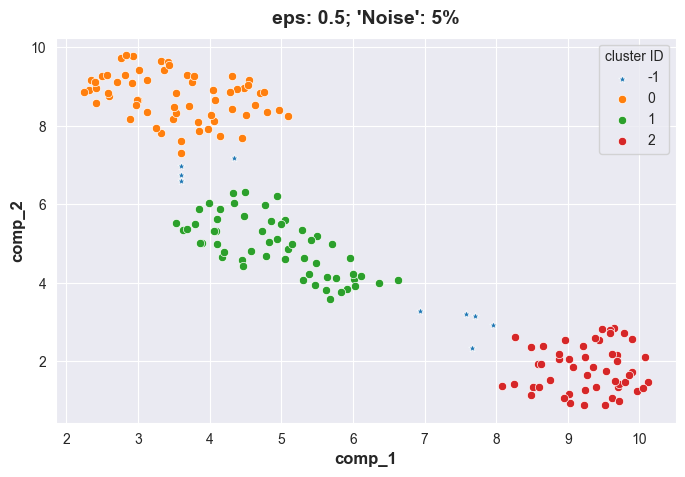

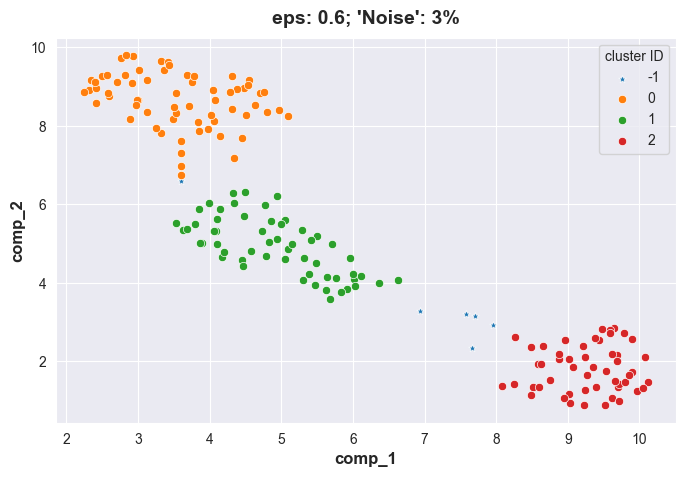

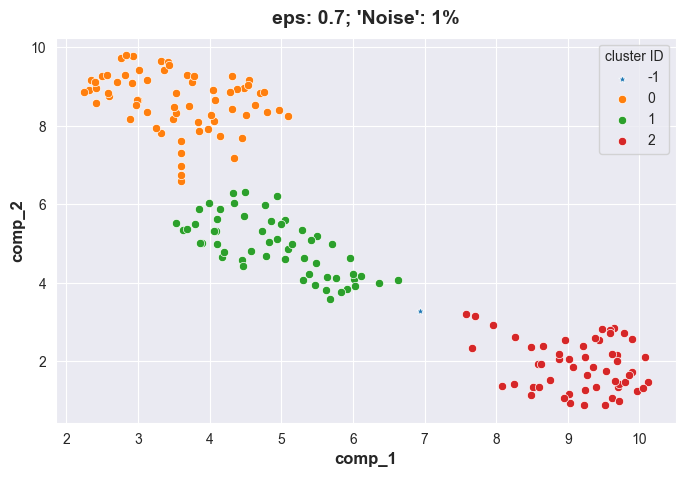

CPU times: total: 688 ms
Wall time: 708 ms


In [35]:
%%time

for e in [0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

Answer the following questions:

1- what would be the best value?
   - *Answer:* `eps≈0.6` preserved the three main wine groups while still flagging a handful of fringe points as noise, whereas smaller radii fragmented clusters and larger ones fused them, so 0.6 is the most balanced choice from the sweep.

### Re-run with optimised *eps*

In [36]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

dbscan_opt_training_time = time.time() - start_time

CPU times: total: 46.9 ms
Wall time: 19.4 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

1- How does OPTICS algorithm work? how is it different from DBSCAN?
   - *Answer:* OPTICS orders points by exploring density-reachability similar to DBSCAN, but it records reachability distances rather than committing to a single `eps`. By scanning the ordering (reachability plot) one can extract clusters at multiple density levels, so it decouples cluster detection from a single global radius.

2- What advantage does using a variable neighborhood radius provide compared to DBSCAN’s fixed eps value? 
   - *Answer:* A variable radius allows OPTICS to adapt to local density changes, preserving sparse clusters alongside dense ones without choosing a single `eps` that either merges dense regions or shatters sparse ones.

3- In what types of datasets would OPTICS likely outperform DBSCAN? Give an example of a data distribution.
   - *Answer:* Datasets with clusters of widely varying densities—e.g., a mix of compact city centers and diffuse suburbs in geospatial data—benefit because OPTICS can uncover both density scales in one run, whereas DBSCAN would require separate `eps` choices.

In [37]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

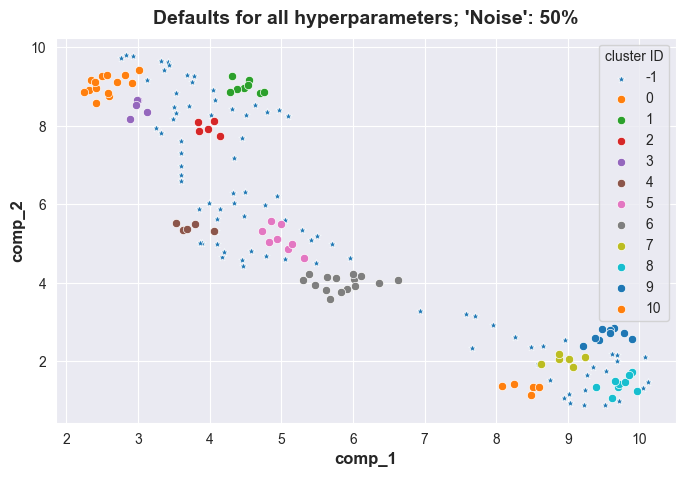

CPU times: total: 2.38 s
Wall time: 3.5 s


In [38]:
%%time

start_time = time.time()

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

training_times.append(time.time() - start_time)

Answer the following questions:

1- what are the blue dots in the result?
   - *Answer:* They are noise points labeled `-1`, i.e., samples that OPTICS could not assign to any cluster under the current reachability threshold.

2- how does the option Noise Exists affect the result?
   - *Answer:* When `noise_exist=True` in the visualization helper, cluster `-1` is plotted with a distinct marker (blue stars), making it obvious which observations OPTICS treated as outliers; the underlying labels from OPTICS are unchanged.

### Tuning runs

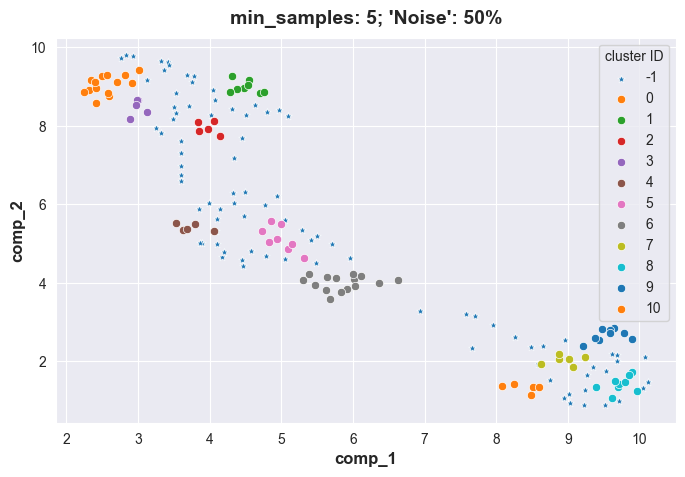

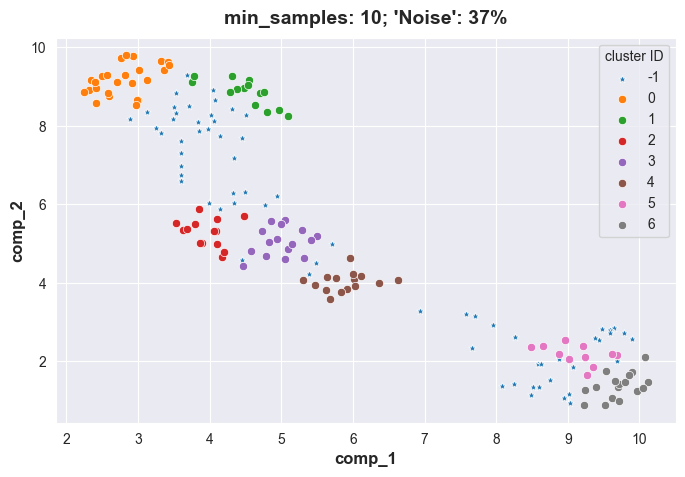

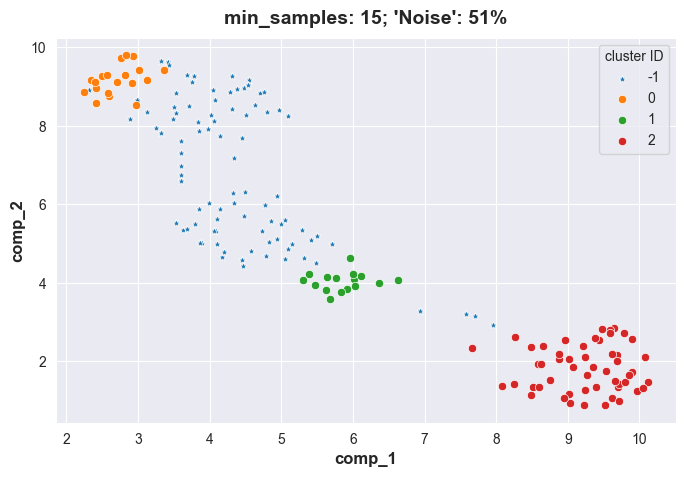

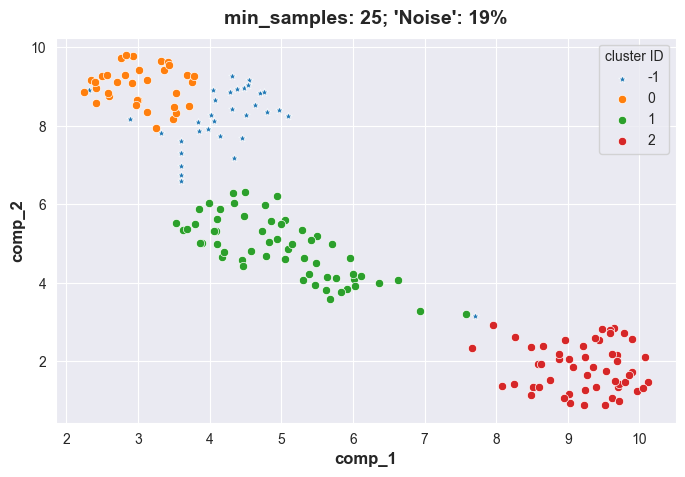

CPU times: total: 9.75 s
Wall time: 14.8 s


In [39]:
%%time

for n_samples in [5, 10, 15, 25]: 
    
    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)
    
    labels_6 = optics.fit_predict(X)
    
    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

### Re-run with optimised value

In [40]:
%%time

n_samples = 15 

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

optics_opt_training_time = time.time() - start_time

CPU times: total: 1.84 s
Wall time: 3.18 s


# Comparison of training times

['K-means', 'Mean shift', 'Gaussian mixtures', 'Affinity propagation', 'DBSCAN', 'OPTICS']
[0.010378599166870117, 5.93867564201355, 0.010746479034423828, 0.009674787521362305, 0.14094257354736328, 3.4976251125335693]


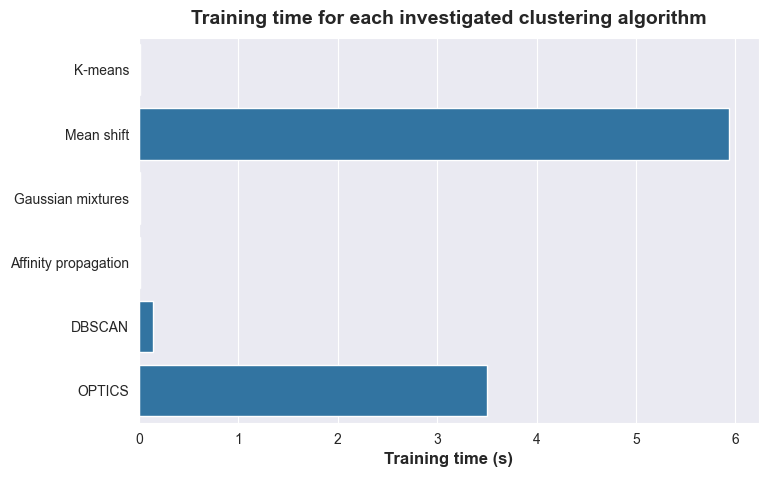

In [41]:
plt.figure(figsize=std_figure_size)
print(algos)
print(training_times)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

Answer the following questions:

1- why do the training times of Mean Shift and OPTICS stand out compared to the other algorithms?
   - *Answer:* Both iterate over dense neighborhood searches for every point (Mean Shift repeatedly recomputes kernel means, OPTICS maintains priority queues while expanding reachability), so their complexity grows roughly quadratically with sample size, whereas the other algorithms have cheaper iterations.

2- What effect does setting cluster_all=False have on the training time of the Mean Shift algorithm, and why might this occur?
   - *Answer:* It can shorten the run because the algorithm no longer needs to keep nudging low-density orphan points toward a cluster; once their mode search fails, they are labeled as noise and skipped in later iterations.

3- How can the variation in training times influence the choice of a clustering algorithm in practical applications?
   - *Answer:* When latency or compute budget is tight (e.g., interactive analytics, embedded systems), practitioners often favor faster methods even if they sacrifice some accuracy, reserving heavier algorithms for offline or high-stakes analyses.

4- Why do algorithms like K-means or GMM have much faster training times compared to Mean Shift and OPTICS?
   - *Answer:* K-means and GMM have closed-form updates that require only a pass over the data per iteration, using global cluster statistics; they don’t maintain per-point neighborhood structures, so their per-iteration cost is linear in the number of samples.

5- In a dataset with a large number of points, which factors in an algorithm’s design might contribute most to increased training time?
   - *Answer:* Expensive nearest-neighbor searches, repeated distance computations, and global data structures that scale with `n²` (e.g., similarity matrices) dominate runtime, especially if the algorithm revisits them many times.

6- How might the dimensionality of data affect the relative training times of these clustering algorithms?
   - *Answer:* Higher dimensions inflate distance computations and can degrade spatial indexing, so density-based methods that rely on neighborhoods slow down disproportionately, while centroid-based methods experience a milder increase tied mainly to computing means and covariances.

In [42]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

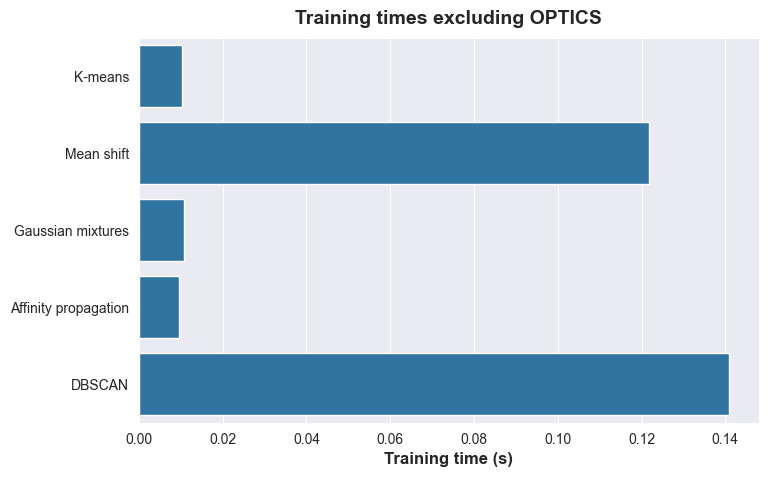

In [43]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()

# Conclusions

As with practically everything else in the machine learning domain, when it comes to clustering there is no "one-size-fits-all" algorithm. Different algorithms tend to be better depending on the structure of the data and in particluar **to what extent this structure is in line with what each algorithm relies on in order to work satisfactorily**. For the relatively simple data structure of the "wine dataset", practically all investigated algorithms performed well (after more or less hyperparameter turning).

Two important caveats regarding the results of this "study":
- Only the **single "most important" hyperparameter** was considered for tuning for each algorithm.
- The **dataset** employed here is **very small**. For datasets of a more real-world size, the relative performance in terms of training times will most likely be different. 